# SMAP Project

## Installation and import

In [1]:
%pip install -q tensorflow matplotlib tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load and visualize the dataset

In [25]:
batch_size = 32
img_height = 128
img_width = 128
data_dir = r'C:\Users\Admin\tensorflow_datasets\MiniPlaces'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 100000 files belonging to 100 classes.
Using 80000 files for training.
Found 100000 files belonging to 100 classes.
Using 20000 files for validation.
['abbey', 'airport_terminal', 'amphitheater', 'amusement_park', 'aquarium', 'aqueduct', 'art_gallery', 'assembly_line', 'auditorium', 'badlands', 'bakery', 'ballroom', 'bamboo_forest', 'banquet_hall', 'bar', 'baseball_field', 'bathroom', 'beauty_salon', 'bedroom', 'boat_deck', 'bookstore', 'botanical_garden', 'bowling_alley', 'boxing_ring', 'bridge', 'bus_interior', 'butchers_shop', 'campsite', 'candy_store', 'canyon', 'cemetery', 'chalet', 'church', 'classroom', 'clothing_store', 'coast', 'cockpit', 'coffee_shop', 'conference_room', 'construction_site', 'corn_field', 'corridor', 'courtyard', 'dam', 'desert', 'dining_room', 'driveway', 'fire_station', 'food_court', 'fountain', 'gas_station', 'golf_course', 'harbor', 'highway', 'hospital_room', 'hot_spring', 'ice_skating_rink', 'iceberg', 'kindergarden_classroom', 'kitchen', 'laundro

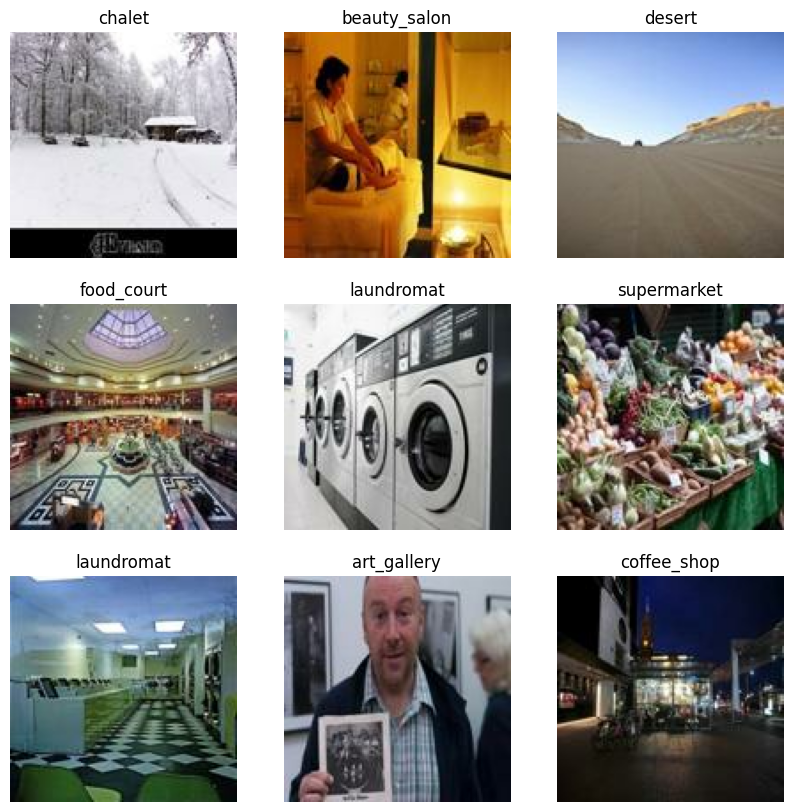

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [27]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


## Preprocess dataset

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Check
print(np.min(first_image), np.max(first_image))

## Normalization will be inside models

0.0 1.0


## First Model

### Create

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

### Train

In [18]:
epochs=10

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2500/2500 [==============================] - 308s 120ms/step - loss: 3.8340 - accuracy: 0.1095 - val_loss: 3.4225 - val_accuracy: 0.1744
Epoch 2/10
2500/2500 [==============================] - 279s 112ms/step - loss: 3.2067 - accuracy: 0.2133 - val_loss: 3.2144 - val_accuracy: 0.2133
Epoch 3/10
2500/2500 [==============================] - 280s 112ms/step - loss: 2.8631 - accuracy: 0.2777 - val_loss: 3.2294 - val_accuracy: 0.2214
Epoch 4/10
2500/2500 [==============================] - 277s 111ms/step - loss: 2.5172 - accuracy: 0.3488 - val_loss: 3.3486 - val_accuracy: 0.2157
Epoch 5/10
2500/2500 [==============================] - 276s 110ms/step - loss: 2.1678 - accuracy: 0.4245 - val_loss: 3.6918 - val_accuracy: 0.2009
Epoch 6/10
2500/2500 [==============================] - 275s 110ms/step - loss: 1.8245 - accuracy: 0.5044 - val_loss: 4.0798 - val_accuracy: 0.1873
Epoch 7/10
2500/2500 [==============================] - 279s 112ms/step - loss: 1.5183 - accuracy: 0.5767 - val_loss: 4.648

### Visualization of results

In [34]:
def plot_training_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    
    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    # Show the plot
    plt.show()

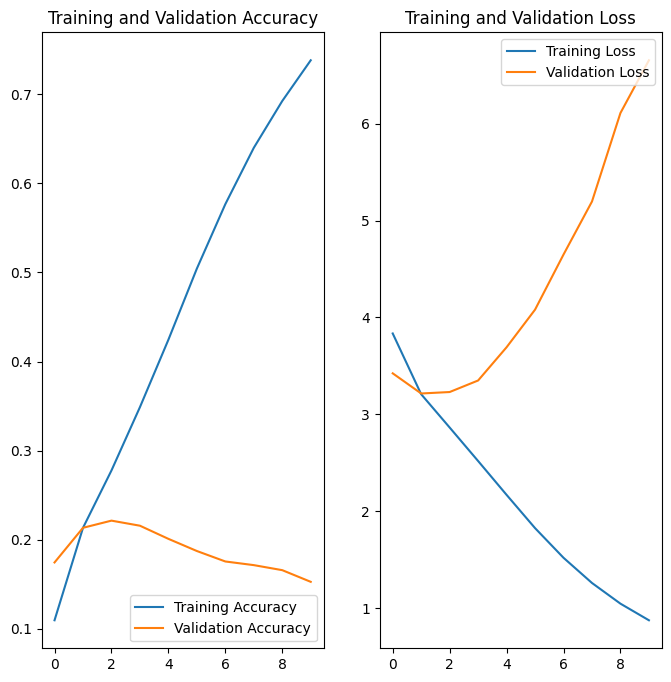

In [ ]:
plot_training_history(history, epochs)

* the graphs show that the training accuracy increases linearly over time, while the validation accuracy stops around 20% in the training process
* the difference in accuracy between training and validation is large, which could point to an overfitting problem
* I will try to add data augmentation and dropout to fix this problem

## Augmentation 

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

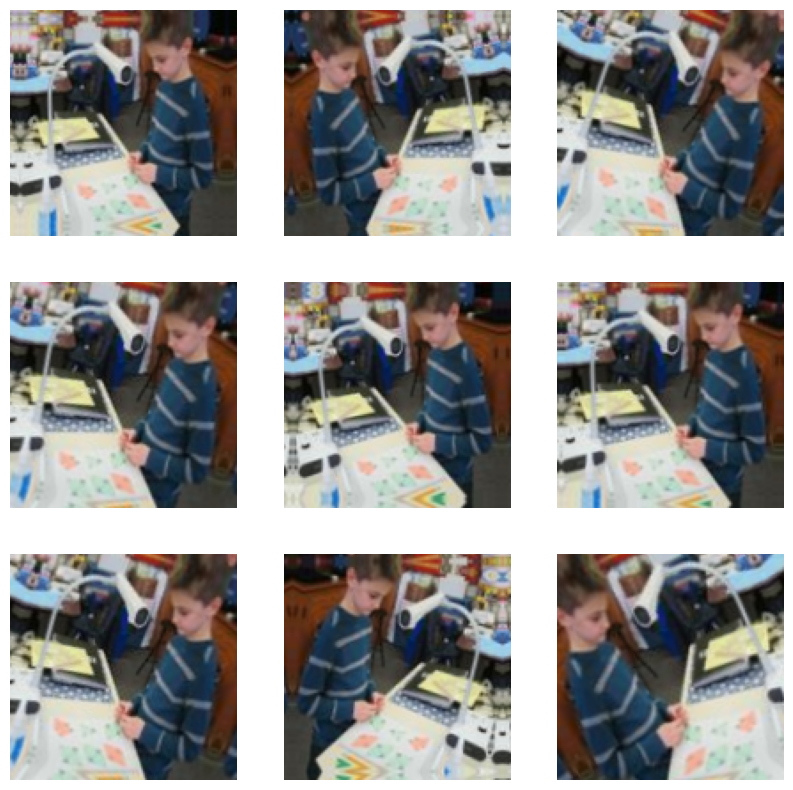

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Second Model

### Create

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                 

### Train

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2500/2500 [==============================] - 319s 127ms/step - loss: 3.9756 - accuracy: 0.0906 - val_loss: 3.6904 - val_accuracy: 0.1354
Epoch 2/10
2500/2500 [==============================] - 319s 127ms/step - loss: 3.5002 - accuracy: 0.1633 - val_loss: 3.4093 - val_accuracy: 0.1817
Epoch 3/10
2500/2500 [==============================] - 326s 131ms/step - loss: 3.3548 - accuracy: 0.1892 - val_loss: 3.2663 - val_accuracy: 0.2056
Epoch 4/10
2500/2500 [==============================] - 330s 132ms/step - loss: 3.2681 - accuracy: 0.2022 - val_loss: 3.2731 - val_accuracy: 0.2101
Epoch 5/10
2500/2500 [==============================] - 340s 136ms/step - loss: 3.2074 - accuracy: 0.2148 - val_loss: 3.1787 - val_accuracy: 0.2181
Epoch 6/10
2500/2500 [==============================] - 332s 133ms/step - loss: 3.1641 - accuracy: 0.2235 - val_loss: 3.1785 - val_accuracy: 0.2198
Epoch 7/10
2500/2500 [==============================] - 320s 128ms/step - loss: 3.1275 - accuracy: 0.2280 - val_

### Visualization of results

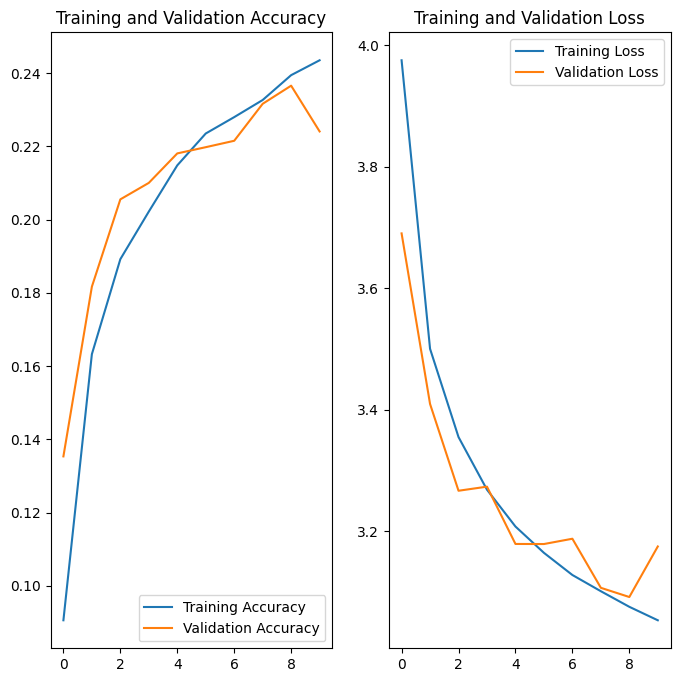

In [ ]:
plot_training_history(history, epochs)

* here we can see much better results
* training and validation accuracy/loss is holding near each other
* because accuracy/loss was still increasing/decreasing over epochs I will try add some more epochs on the same model and run again

### More training

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2500/2500 [==============================] - 340s 136ms/step - loss: 3.0322 - accuracy: 0.2470 - val_loss: 3.1054 - val_accuracy: 0.2371
Epoch 2/10
2500/2500 [==============================] - 334s 134ms/step - loss: 3.0133 - accuracy: 0.2495 - val_loss: 3.0850 - val_accuracy: 0.2373
Epoch 3/10
2500/2500 [==============================] - 331s 133ms/step - loss: 2.9977 - accuracy: 0.2543 - val_loss: 3.1030 - val_accuracy: 0.2391
Epoch 4/10
2500/2500 [==============================] - 332s 133ms/step - loss: 2.9932 - accuracy: 0.2539 - val_loss: 3.0999 - val_accuracy: 0.2347
Epoch 5/10
2500/2500 [==============================] - 329s 132ms/step - loss: 2.9717 - accuracy: 0.2585 - val_loss: 3.0973 - val_accuracy: 0.2366
Epoch 6/10
2500/2500 [==============================] - 343s 137ms/step - loss: 2.9633 - accuracy: 0.2591 - val_loss: 3.1263 - val_accuracy: 0.2331
Epoch 7/10
2500/2500 [==============================] - 358s 143ms/step - loss: 2.9483 - accuracy: 0.2632 - val_

### Visualization of results

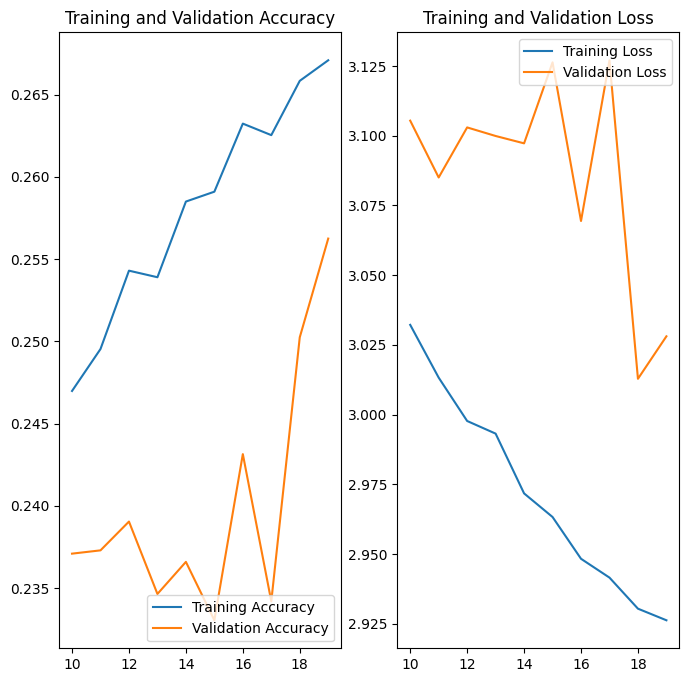

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
epochs_range = [num + epochs for num in epochs_range]

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* unfortunately more epochs help very little
* I will try transfer learning to raise accuracy

## Transfer Learning

In [29]:
feature_extractor_model = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(128, 128, 3),
    trainable=False
    )

In [30]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1001)


In [31]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1001)              1692489   
                                                                 
 dense_2 (Dense)             (None, 100)               100200    
                                                                 
Total params: 1792689 (6.84 MB)
Trainable params: 100200 (391.41 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [33]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10


2500/2500 [==============================] - 266s 100ms/step - loss: 3.2991 - accuracy: 0.2553 - val_loss: 2.8500 - val_accuracy: 0.3318
Epoch 2/10
2500/2500 [==============================] - 217s 87ms/step - loss: 3.0250 - accuracy: 0.3023 - val_loss: 2.8933 - val_accuracy: 0.3390
Epoch 3/10
2500/2500 [==============================] - 237s 95ms/step - loss: 2.9654 - accuracy: 0.3111 - val_loss: 2.7925 - val_accuracy: 0.3442
Epoch 4/10
2500/2500 [==============================] - 237s 95ms/step - loss: 2.9179 - accuracy: 0.3198 - val_loss: 2.7536 - val_accuracy: 0.3528
Epoch 5/10
2500/2500 [==============================] - 227s 91ms/step - loss: 2.8947 - accuracy: 0.3225 - val_loss: 2.7953 - val_accuracy: 0.3539
Epoch 6/10
2500/2500 [==============================] - 215s 86ms/step - loss: 2.8758 - accuracy: 0.3283 - val_loss: 2.8450 - val_accuracy: 0.3471
Epoch 7/10
2500/2500 [==============================] - 216s 86ms/step - loss: 2.8600 - accuracy: 0.3316 - val_loss: 2.7856 - va

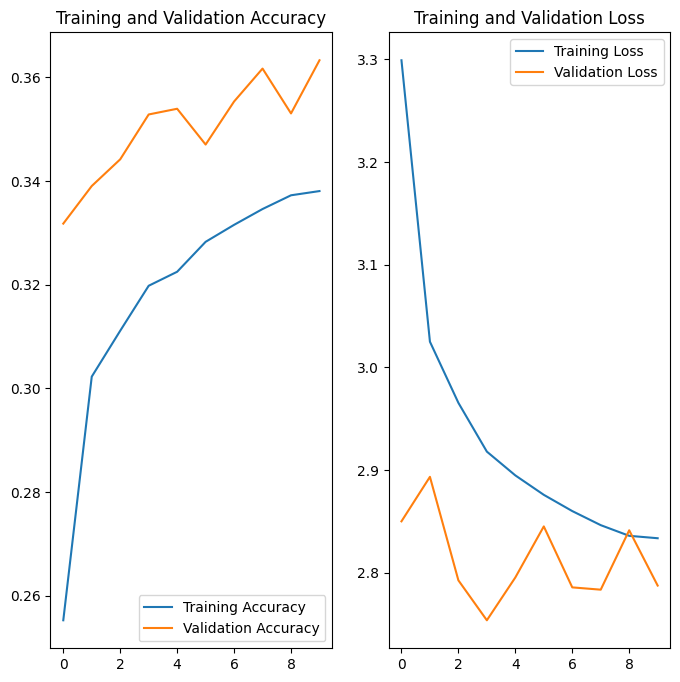

In [35]:
plot_training_history(history, epochs)

## Predictions on new data - TODO

In [51]:
image_path = r'C:\Users\Admin\tensorflow_datasets\VisDrone2019-DET-val\intersection.jpg'

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 98ms/step
This image most likely belongs to intersection with a 90.35 percent confidence.
